In [1]:
from nlb_tools.nwb_interface import NWBDataset
import numpy as np
import matplotlib.pyplot as plt
from Area2_analysis.lr_funcs import nans
from pyglmnet import GLMCV, GLM
from scipy import stats
from Area2_analysis.glm_funcs import resample, mp_glm_pr2, mp_cross_glm_pr2, pred_cross_glm
import multiprocessing as mp
from matplotlib.patches import Patch
import matplotlib
matplotlib.rc('font', size=18)

2024-05-14 18:33:19.949164: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
foldername = "~/area2_population_analysis/s1-kinematics/actpas_NWB/"
monkey = "Chips_20170913"
filename = foldername + monkey + "_COactpas_TD.nwb"

dataset = NWBDataset(filename, split_heldout=False)
xy_vel = dataset.data['hand_vel'].to_numpy()
xy_acc = np.diff(xy_vel, axis = 0, prepend=[xy_vel[0]])
dataset.add_continuous_data(xy_acc,'hand_acc',chan_names = ['x','y'])

bin_width = dataset.bin_width
print(bin_width)

1


In [3]:
active_mask = (~dataset.trial_info.ctr_hold_bump) & (dataset.trial_info.split != 'none')
passive_mask = (dataset.trial_info.ctr_hold_bump) & (dataset.trial_info.split != 'none')
all_mask = (dataset.trial_info.split != 'none')

n_neurons = dataset.data.spikes.shape[1]
print(n_neurons,'neurons')

57 neurons


In [4]:
#make dictionary for trial condition (reaching directions) for Stratified CV
trial_mask = active_mask
active_trials_idx = np.array(dataset.trial_info.loc[trial_mask]['trial_id'])
active_n_trials = dataset.trial_info.loc[trial_mask].shape[0]
print(active_n_trials,'active trials')

trial_mask = passive_mask
passive_trials_idx = np.array(dataset.trial_info.loc[trial_mask]['trial_id'])
passive_n_trials = dataset.trial_info.loc[trial_mask].shape[0]
print(passive_n_trials,'passive trials')

active_cond_dir_idx = []
passive_cond_dir_idx = []
# for direction in [0,45,90,135,180,225,270,315]:
for direction in [0,90,180,270]:
    active_cond_dir_idx.append(np.where((dataset.trial_info['cond_dir'] == direction) & (dataset.trial_info['ctr_hold_bump'] == False) & \
           (dataset.trial_info['split'] != 'none'))[0])
    passive_cond_dir_idx.append(np.where((dataset.trial_info['bump_dir'] == direction) & (dataset.trial_info['ctr_hold_bump'] == True) & \
           (dataset.trial_info['split'] != 'none'))[0])


active_cond_dict = nans([active_n_trials])
i = 0
for idx in active_trials_idx:
    for cond in range(0,len(active_cond_dir_idx)):
        if idx in active_cond_dir_idx[cond]:
            active_cond_dict[i] = cond
            break
    i+=1
print(active_cond_dict)
print(len(active_cond_dict))

passive_cond_dict = nans([passive_n_trials])
i = 0
for idx in passive_trials_idx:
    for cond in range(0,len(passive_cond_dir_idx)):
        if idx in passive_cond_dir_idx[cond]:
            passive_cond_dict[i] = cond
            break
    i+=1
print(passive_cond_dict)
print(len(passive_cond_dict))

663 active trials
615 passive trials
[0. 1. 1. 2. 0. 3. 1. 2. 1. 0. 2. 3. 0. 3. 1. 2. 1. 2. 2. 2. 2. 3. 1. 0.
 3. 3. 3. 3. 2. 2. 3. 1. 1. 2. 1. 2. 1. 2. 0. 3. 3. 1. 2. 1. 0. 2. 0. 0.
 0. 2. 0. 1. 1. 2. 1. 1. 2. 3. 2. 2. 1. 3. 1. 2. 2. 1. 3. 0. 2. 3. 0. 3.
 3. 0. 2. 2. 2. 1. 0. 0. 1. 1. 2. 0. 0. 0. 1. 0. 1. 2. 3. 2. 2. 0. 2. 2.
 2. 2. 0. 1. 0. 3. 0. 1. 3. 2. 3. 0. 1. 3. 2. 2. 2. 3. 2. 3. 1. 3. 1. 2.
 3. 1. 3. 1. 2. 1. 1. 1. 0. 1. 0. 1. 2. 2. 0. 0. 1. 2. 1. 2. 2. 2. 3. 3.
 3. 0. 2. 0. 3. 2. 3. 1. 1. 2. 0. 1. 0. 3. 1. 3. 0. 3. 2. 1. 0. 2. 3. 1.
 3. 2. 3. 2. 0. 3. 0. 2. 2. 3. 0. 0. 2. 0. 3. 1. 3. 2. 3. 1. 0. 1. 0. 3.
 0. 2. 3. 0. 1. 1. 2. 3. 2. 2. 2. 3. 1. 2. 3. 0. 1. 3. 2. 0. 3. 0. 2. 1.
 1. 0. 0. 2. 2. 2. 2. 0. 3. 1. 0. 2. 3. 3. 0. 2. 0. 2. 1. 3. 2. 3. 0. 3.
 0. 0. 0. 2. 2. 2. 2. 3. 1. 0. 3. 2. 3. 0. 0. 0. 1. 0. 1. 3. 3. 1. 3. 0.
 0. 2. 1. 2. 1. 0. 3. 1. 1. 1. 0. 1. 2. 0. 2. 0. 3. 0. 1. 3. 2. 2. 2. 3.
 2. 0. 2. 0. 1. 0. 2. 3. 1. 3. 2. 3. 1. 0. 1. 0. 2. 3. 3. 3. 0. 0. 1. 0.
 0. 1. 0. 1. 3

# straight GLM

### Fit

In [22]:
#Data selection params
active_align_range = (0,1000)
passive_align_range = (0,120)

lag_range = np.arange(-200,201,20)
encoding_bin_size = int(20)

active_spikes_df = dataset.make_trial_data(align_field='move_onset_time', align_range=active_align_range, ignored_trials=~active_mask)
active_spikes_resampled = resample(active_spikes_df.spikes.to_numpy(),encoding_bin_size)*1000 

passive_spikes_df = dataset.make_trial_data(align_field='move_onset_time', align_range=passive_align_range, ignored_trials=~passive_mask)
passive_spikes_resampled = resample(passive_spikes_df.spikes.to_numpy(),encoding_bin_size)*1000

# fr_thresh = 1 #in Hz
# neuron_filter = np.logical_and(np.mean(active_spikes_resampled,axis = 0) > fr_thresh, np.mean(passive_spikes_resampled,axis = 0) > fr_thresh)
# neuron_filter = np.mean(active_spikes_resampled,axis = 0) > fr_thresh
# np.savez(monkey+'_hf_neuron_filter', neuron_filter = neuron_filter)
with np.load(monkey+'_hf_neuron_filter.npz') as data:
    neuron_filter = data['neuron_filter']
n_high_neurons = np.sum(neuron_filter)
print(n_high_neurons,'high fr neurons')

active_n_timepoints = int((active_align_range[1] - active_align_range[0])/encoding_bin_size)
print(active_n_timepoints,'timepoints')
passive_n_timepoints = int((passive_align_range[1] - passive_align_range[0])/encoding_bin_size)
print(passive_n_timepoints,'timepoints')


active_behav_df = dataset.make_trial_data(align_field='move_onset_time', align_range=active_align_range, ignored_trials=~active_mask)
active_behav = active_behav_df['hand_acc'].to_numpy()
# active_behav_df_1 = dataset.make_trial_data(align_field='move_onset_time', align_range=(active_align_range[0]+l2, active_align_range[1]+l2), ignored_trials=~active_mask)
# active_behav = np.concatenate((active_behav_df['hand_acc'].to_numpy(),active_behav_df_1['hand_acc'].to_numpy()),axis=1)
active_behav_resampled = resample(active_behav,encoding_bin_size)

passive_behav_df = dataset.make_trial_data(align_field='move_onset_time', align_range=passive_align_range, ignored_trials=~passive_mask)
passive_behav = passive_behav_df['hand_acc'].to_numpy()
# passive_behav_df_1 = dataset.make_trial_data(align_field='move_onset_time', align_range=passive_align_range, ignored_trials=~passive_mask)
# passive_behav = np.concatenate((passive_behav_df['hand_acc'].to_numpy(),passive_behav_df_1['hand_vel'].to_numpy()),axis=1)
passive_behav_resampled = resample(passive_behav,encoding_bin_size)

#Active
X_reshaped = active_behav_resampled.reshape(active_n_trials, active_n_timepoints, -1)
# pool = mp.Pool(mp.cpu_count())
# active_pR2 = [pool.starmap(mp_glm_pr2, [(dataset, X_reshaped, active_mask, active_cond_dict, neuron_filter, encoding_bin_size, active_align_range, lag) for lag in lag_range])][0]
# pool.close()
active_pR2 = [mp_glm_pr2(dataset, X_reshaped, active_mask, active_cond_dict, neuron_filter, encoding_bin_size, active_align_range, lag) for lag in lag_range]

#Passive
X_reshaped = passive_behav_resampled.reshape(passive_n_trials, passive_n_timepoints, -1)
# pool = mp.Pool(mp.cpu_count())
# passive_pR2 = [pool.starmap(mp_glm_pr2, [(dataset, X_reshaped, passive_mask, passive_cond_dict, neuron_filter, encoding_bin_size, passive_align_range, lag) for lag in lag_range])][0]
# pool.close()
passive_pR2 = [mp_glm_pr2(dataset, X_reshaped, passive_mask, passive_cond_dict, neuron_filter, encoding_bin_size, passive_align_range, lag) for lag in lag_range]


np.savez(monkey+'_A20_1k120_pR2', active_pR2 = active_pR2, passive_pR2 = passive_pR2) 

52 high fr neurons
50 timepoints
6 timepoints


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(
/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(
/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(
/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(
/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(
/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(
/Users/sherryan/

Text(0.5, 1.0, 'Distribution of trial-averaged firing rates')

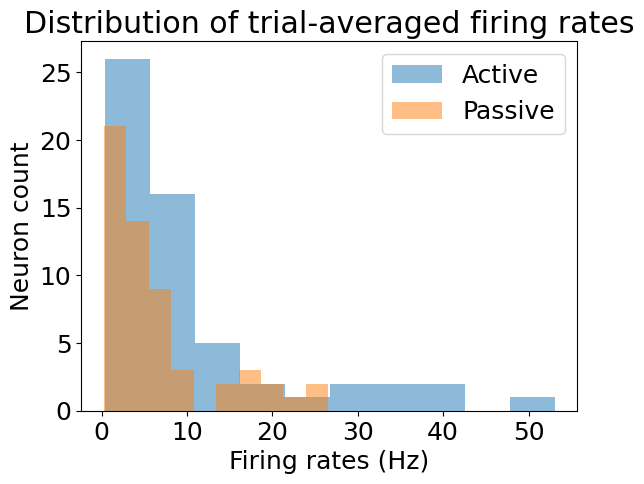

In [7]:
plt.hist(np.mean(active_spikes_resampled,axis = 0),alpha  =0.5, label = 'Active')
plt.hist(np.mean(passive_spikes_resampled,axis = 0),alpha = 0.5,label = 'Passive')
plt.xlabel('Firing rates (Hz)')
plt.ylabel('Neuron count')
plt.legend()
plt.title('Distribution of trial-averaged firing rates')

### Plot

### Variable paired lags

In [117]:
monkey = "Han_20171207"
figDir = '/Users/sherryan/area2_population_analysis/figures_plus/'
with np.load(monkey+'_encoding_A_VarPair_1kActive_pR2.npz') as data:
    variable_lag_active_pR2 = data['variable_lag_active_pR2']
print(variable_lag_active_pR2.shape)

(3, 136)


([<matplotlib.axis.XTick at 0x7fe9f938eb20>,
 [Text(0, 0, '-150/-50'), Text(1, 0, '-50/+50'), Text(2, 0, '+50/+150')])

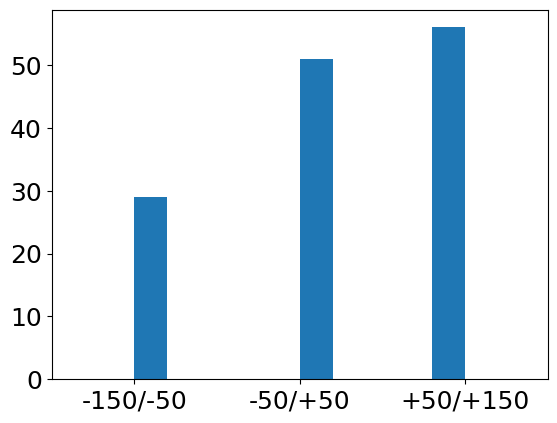

In [118]:
plt.hist(np.argmax(variable_lag_active_pR2,axis=0))
plt.xlim([-0.5,2.5])
plt.xticks(ticks=[0,1,2],labels=['-150/-50','-50/+50','+50/+150'])

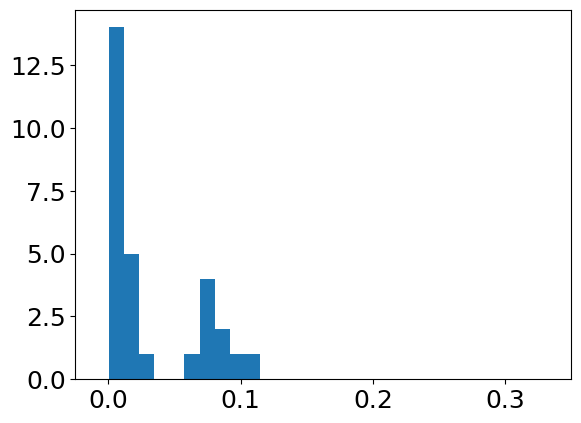

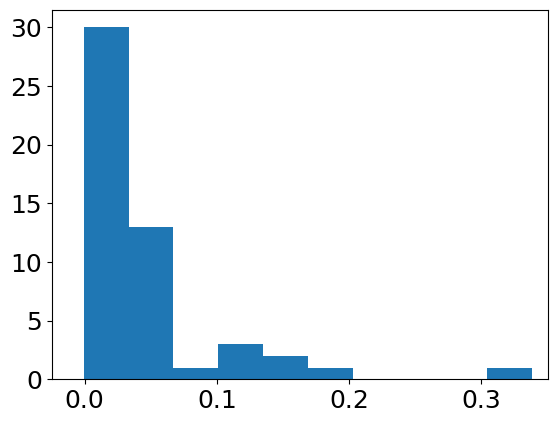

(-0.025, 0.35)

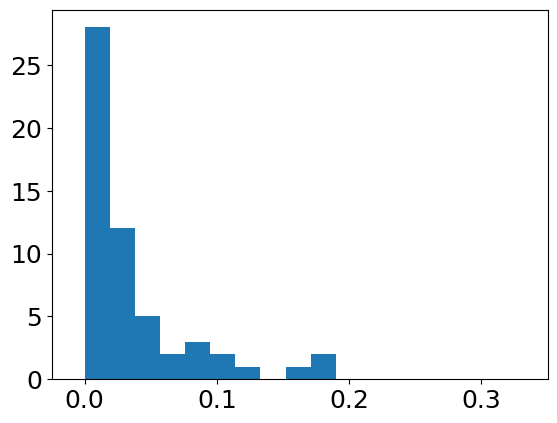

In [122]:
plt.hist(np.max(variable_lag_active_pR2,axis=0)[np.argmax(variable_lag_active_pR2,axis=0)==0])
plt.xlim(-0.025,0.35)
plt.show()
plt.hist(np.max(variable_lag_active_pR2,axis=0)[np.argmax(variable_lag_active_pR2,axis=0)==1])
plt.xlim(-0.025,0.35)
plt.show()
plt.hist(np.max(variable_lag_active_pR2,axis=0)[np.argmax(variable_lag_active_pR2,axis=0)==2])
plt.xlim(-0.025,0.35)


### w/o Thresh

In [23]:
monkey = "Chips_20170913"
figDir = '/Users/sherryan/area2_population_analysis/figures_plus/'
with np.load(monkey+'_A20_1k120_pR2.npz') as data:
    active_pR2 = data['active_pR2']
    passive_pR2 = data['passive_pR2']
lag_range = np.arange(-200,201,20)


In [9]:
n_high_neurons = active_pR2.shape[1]
print(n_high_neurons,'neurons')

52 neurons


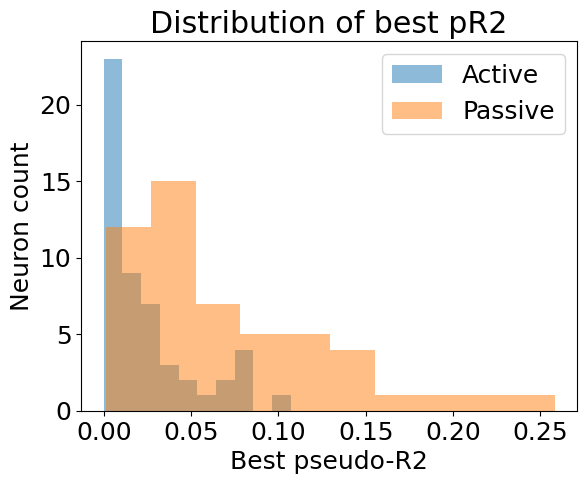

In [24]:
active_r2s = np.nanmax(active_pR2,axis = 0) #highest pr2 in active condition that encode all neurons
passive_r2s = np.nanmax(passive_pR2,axis = 0) #pasisve condition
plt.hist(active_r2s,alpha = 0.5,label = 'Active')
plt.hist(passive_r2s,alpha = 0.5,label = 'Passive')
plt.xlabel("Best pseudo-R2")
plt.ylabel("Neuron count")
plt.title('Distribution of best pR2')
plt.legend()

[ModeResult(mode=array([-60]), count=array([9])), ModeResult(mode=array([140]), count=array([9]))]


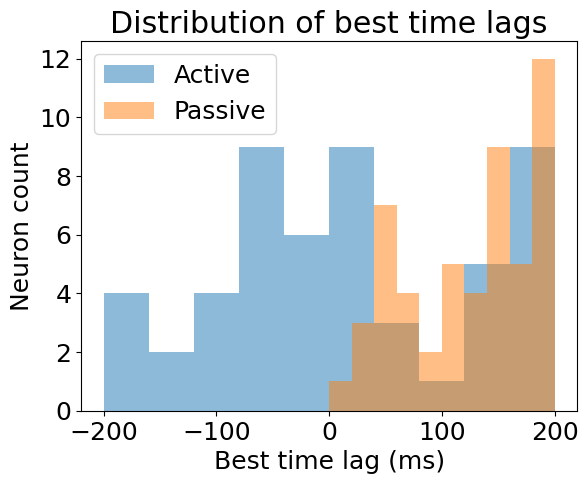

In [25]:
active_lags = lag_range[np.argmax(active_pR2,axis = 0)] #best time lags in active condition that encode all neurons
passive_lags = lag_range[np.argmax(passive_pR2,axis = 0)] #pasisve condition
plt.hist(active_lags,alpha = 0.5,label = 'Active')
plt.hist(passive_lags,alpha = 0.5,label = 'Passive')
plt.xlabel("Best time lag (ms)")
plt.ylabel("Neuron count")
plt.title('Distribution of best time lags')
plt.legend()
print([stats.mode(active_lags), stats.mode(passive_lags)])

Mean: [8.461538461538462, 116.53846153846153]
Median: [0.0, 130.0]


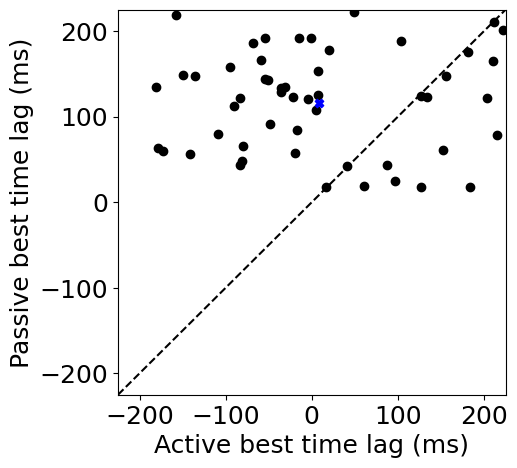

In [26]:
# Add jitter to best time lags for visualization
NOISE = 25
active_lags_rand = np.add(active_lags, np.random.uniform(low=-NOISE, high=NOISE, size=(len(active_lags),)))
passive_lags_rand = np.add(passive_lags, np.random.uniform(low=-NOISE, high=NOISE, size=(len(passive_lags),)))

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlim(-225,225)
ax.set_ylim(-225,225)
ax.set_xlabel("Active best time lag (ms)")
ax.set_ylabel("Passive best time lag (ms)")
ax.scatter(active_lags_rand, passive_lags_rand,color = 'k')
ax.scatter(np.mean(active_lags), np.mean(passive_lags), marker = 'X', color = 'blue')
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="k")
print('Mean:',[np.mean(active_lags),np.mean(passive_lags)])
print('Median:',[np.median(active_lags),np.median(passive_lags)])

[0.034998236962611416, 0.07311838891929509]


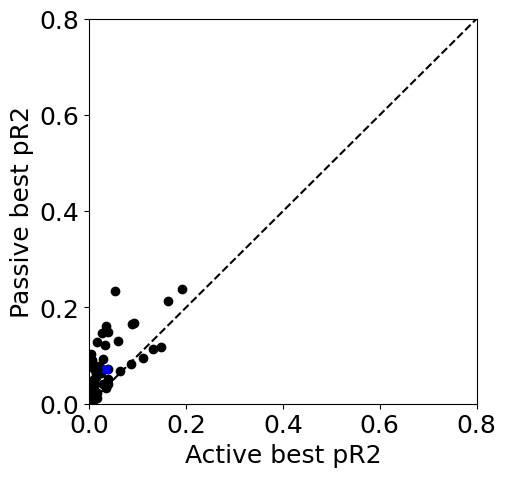

In [13]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlim(0,0.8)
ax.set_ylim(0,0.8)
ax.set_ylabel("Passive best pR2")
ax.set_xlabel("Active best pR2")
ax.scatter(active_r2s, passive_r2s,color = 'k')
ax.scatter(np.mean(active_r2s), np.mean(passive_r2s), marker = 'X', color = 'blue')
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="k")
print([np.mean(active_r2s),np.mean(passive_r2s)])

#### Different variables

In [ ]:
monkey = "Han_20171207"
figDir = '/Users/sherryan/area2_population_analysis/figures_plus/'
with np.load(monkey+'_encoding_V100_1k120_pR2.npz') as data:
    V_active_pR2 = data['active_pR2']
    V_passive_pR2 = data['passive_pR2']

monkey = "Han_20171207"
with np.load(monkey+'_encoding_A100_1k120_pR2.npz') as data:
    A_active_pR2 = data['active_pR2']
    A_passive_pR2 = data['passive_pR2']

In [ ]:
V_active_r2s = np.nanmax(V_active_pR2,axis = 0) #highest pr2 in active condition that encode all neurons
A_active_r2s = np.nanmax(A_active_pR2,axis = 0) #pasisve condition
plt.hist(V_active_r2s,alpha = 0.5,color = 'green',label = 'Velocity')
plt.hist(A_active_r2s,alpha = 0.5,color = 'purple',label = 'Acceleration')
plt.xlabel("Best pseudo-R2")
plt.ylabel("Neuron count")
plt.title('Distribution of best pR2')
plt.legend(prop={'size': 10})

In [ ]:
V_active_lags = lag_range[np.argmax(V_active_pR2,axis = 0)] #best time lags in active condition that encode all neurons
A_active_lags = lag_range[np.argmax(A_active_pR2,axis = 0)] #pasisve condition
plt.hist(V_active_lags,alpha = 0.5,color = 'green',label = 'Velocity')
plt.hist(A_active_lags,alpha = 0.5,color = 'purple',label = 'Acceleration')
plt.xlabel("Best time lag (ms)")
plt.ylabel("Neuron count")
plt.title('Distribution of best time lags')
plt.legend(prop={'size': 10})
print([stats.mode(V_active_lags), stats.mode(A_active_lags)])

In [ ]:
# Add jitter to best time lags for visualization
NOISE = 25
V_active_lags_rand = np.add(V_active_lags, np.random.uniform(low=-NOISE, high=NOISE, size=(len(V_active_lags),)))
A_active_lags_rand = np.add(A_active_lags, np.random.uniform(low=-NOISE, high=NOISE, size=(len(A_active_lags),)))

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlim(-225,225)
ax.set_ylim(-225,225)
ax.set_xlabel("Velocity best time lag (ms)")
ax.set_ylabel("Acceleration best time lag (ms)")
ax.scatter(V_active_lags_rand, A_active_lags_rand,color = 'k')
ax.scatter(np.mean(V_active_lags_rand), np.mean(A_active_lags_rand), marker = 'X', color = 'blue')
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="k")
print('Mean:',[np.mean(V_active_lags_rand),np.mean(A_active_lags_rand)])
print('Median:',[np.median(V_active_lags_rand),np.median(A_active_lags_rand)])

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlim(0,0.8)
ax.set_ylim(0,0.8)
ax.set_xlabel("Velocity best pR2")
ax.set_ylabel("Acceleration best pR2")
ax.scatter(V_active_r2s, A_active_r2s,color = 'k')
ax.scatter(np.mean(V_active_r2s), np.mean(A_active_r2s), marker = 'X', color = 'blue')
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="k")
print([np.mean(V_active_r2s),np.mean(A_active_r2s)])

#### Different lags

In [ ]:
monkey = "Han_20171207"
figDir = '/Users/sherryan/area2_population_analysis/figures_plus/'
with np.load(monkey+'_encoding_VA100100_1k120_pR2.npz') as data:
    wo_active_pR2 = data['active_pR2']
    wo_passive_pR2 = data['passive_pR2']

monkey = "Han_20171207"
with np.load(monkey+'_encoding_lagV150_VA100100_1k120_pR2.npz') as data:
    w_active_pR2 = data['active_pR2']
    w_passive_pR2 = data['passive_pR2']

In [ ]:
wo_active_r2s = np.nanmax(wo_active_pR2,axis = 0) #highest pr2 in active condition that encode all neurons
w_active_r2s = np.nanmax(w_active_pR2,axis = 0) 
plt.hist(wo_active_r2s,alpha = 0.5,color = 'red',label = 'Same lag')
plt.hist(w_active_r2s,alpha = 0.5,color = 'yellow',label = 'Diff lag')
plt.xlabel("Best pseudo-R2")
plt.ylabel("Neuron count")
plt.title('Distribution of best pR2')
plt.legend(prop={'size': 10})

In [ ]:
wo_active_lags = lag_range[np.argmax(wo_active_pR2,axis = 0)] #best time lags in active condition that encode all neurons
w_active_lags = lag_range[np.argmax(w_active_pR2,axis = 0)] #pasisve condition
plt.hist(wo_active_lags,alpha = 0.5,color = 'red',label = 'Same lag')
plt.hist(w_active_lags,alpha = 0.5,color = 'yellow',label = 'Diff lag')
plt.xlabel("Best time lag (ms)")
plt.ylabel("Neuron count")
plt.title('Distribution of best time lags')
plt.legend(prop={'size': 10})
print([stats.mode(wo_active_lags), stats.mode(w_active_lags)])

In [ ]:
# Add jitter to best time lags for visualization
NOISE = 25
wo_active_lags_rand = np.add(wo_active_lags, np.random.uniform(low=-NOISE, high=NOISE, size=(len(wo_active_lags),)))
w_active_lags_rand = np.add(w_active_lags, np.random.uniform(low=-NOISE, high=NOISE, size=(len(w_active_lags),)))

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlim(-225,225)
ax.set_ylim(-225,225)
ax.set_xlabel("Same lag best time lag (ms)")
ax.set_ylabel("Diff lag best time lag (ms)")
ax.scatter(wo_active_lags_rand, w_active_lags_rand,color = 'k')
ax.scatter(np.mean(wo_active_lags_rand), np.mean(w_active_lags_rand), marker = 'X', color = 'blue')
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="k")
print('Mean:',[np.mean(wo_active_lags_rand),np.mean(w_active_lags_rand)])
print('Median:',[np.median(wo_active_lags_rand),np.median(w_active_lags_rand)])

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlim(0,0.8)
ax.set_ylim(0,0.8)
ax.set_xlabel("Same lag best pR2")
ax.set_ylabel("Diff lag best pR2")
ax.scatter(wo_active_r2s, w_active_r2s,color = 'k')
ax.scatter(np.mean(wo_active_r2s), np.mean(w_active_r2s), marker = 'X', color = 'blue')
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="k")
print([np.mean(wo_active_r2s),np.mean(w_active_r2s)])

### Thresh

In [15]:
monkey = "Chips_20170913"
figDir = '/Users/sherryan/area2_population_analysis/figures_plus/'
with np.load(monkey+'_V20_1k120_pR2.npz') as data:
    active_pR2 = data['active_pR2']
    passive_pR2 = data['passive_pR2']

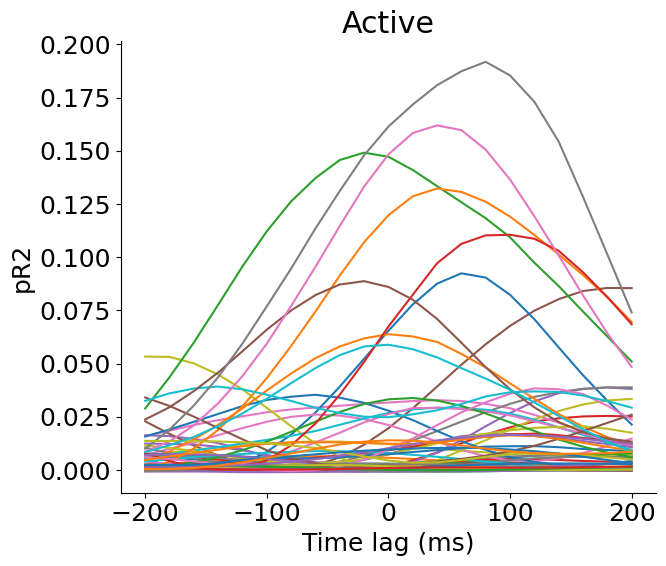

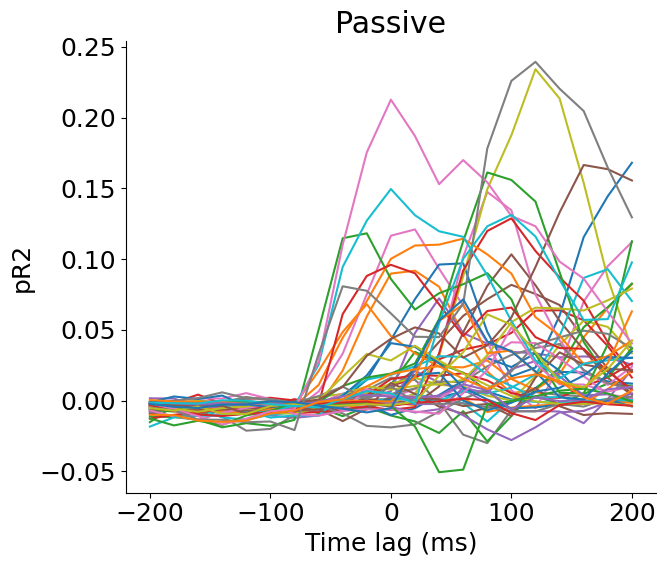

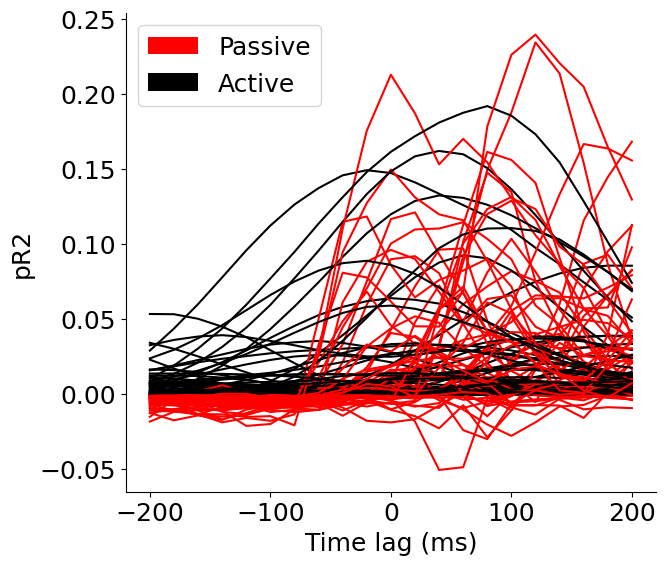

In [16]:
fig, ax = plt.subplots(figsize=(7, 6))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for i in range(n_high_neurons):
    plt.plot(lag_range,active_pR2[:,i])
plt.title('Active')
plt.xlabel('Time lag (ms)')
plt.ylabel('pR2')
plt.tight_layout()
# plt.savefig(figDir + monkey +'_thresh_act.pdf', dpi = 'figure')
plt.show()

fig, ax = plt.subplots(figsize=(7, 6))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for i in range(n_high_neurons):
    plt.plot(lag_range,passive_pR2[:,i])
plt.title('Passive')
plt.xlabel('Time lag (ms)')
plt.ylabel('pR2')
plt.tight_layout()
# plt.savefig(figDir + monkey +'_thresh_pas.pdf', dpi = 'figure')
plt.show()

fig, ax = plt.subplots(figsize=(7, 6))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for i in range(n_high_neurons):
    plt.plot(lag_range,active_pR2[:,i],color = 'k')
    plt.plot(lag_range,passive_pR2[:,i],color = 'red')
plt.xlabel('Time lag (ms)')
plt.ylabel('pR2')
legend_elements = [Patch(facecolor='red', label='Passive'),Patch(facecolor='k', label='Active')]
plt.legend(handles=legend_elements)
# plt.axvline(60,color= 'k', linestyle='--')
plt.tight_layout()
# plt.savefig(figDir + monkey +'_thresh.pdf', dpi = 'figure')
plt.show()

In [20]:
time_threshold_1 = -200
time_threshold_2 = -160
pR2_threshold = 0.05
thresh_active_lags = []
thresh_passive_lags = []
thresh_active_r2s = []
thresh_passive_r2s = []
thresh_idx = []
for i in range(n_high_neurons):
    time_thresh_idx1 = np.argwhere(lag_range==time_threshold_1)[0,0]
    time_thresh_idx2 = np.argwhere(lag_range==time_threshold_2)[0,0]
    act = active_pR2[:,i]
    pas = passive_pR2[:,i]
#     if time_thresh_idx1 <= np.argmax(act) <= time_thresh_idx2 and time_thresh_idx1 <= np.argmax(pas) <= time_thresh_idx2:
    if time_thresh_idx1 <= np.argmax(act) <= time_thresh_idx2 :
#     if np.nanmax(act) >= pR2_threshold and np.nanmax(pas) >= pR2_threshold:
    # if np.nanmax(act)/np.nanmax(pas) > 1.4 and np.nanmax(act) >= pR2_threshold:
    # if np.nanmax(act)/np.nanmax(pas) < 0.7 and np.nanmax(pas) >= pR2_threshold:    
    # if 0.7 < np.nanmax(act)/np.nanmax(pas) < 1.4 and np.nanmax(act) >= pR2_threshold and np.nanmax(pas) >= pR2_threshold:
            thresh_active_r2s.append(np.nanmax(act))
            thresh_passive_r2s.append(np.nanmax(pas))        
            thresh_active_lags.append(lag_range[np.argmax(act)])
            thresh_passive_lags.append(lag_range[np.argmax(pas)])

    # time_thresh_idx1 = np.argwhere(lag_range==time_threshold_1)[0,0]
    # time_thresh_idx2 = np.argwhere(lag_range==time_threshold_2)[0,0]
    # act = active_pR2[time_thresh_idx1:time_thresh_idx2+1,i]
    # pas = passive_pR2[time_thresh_idx1:time_thresh_idx2+1,i]    
    # if np.nanmax(act) >= pR2_threshold and np.nanmax(pas) >= pR2_threshold:
    #     thresh_active_r2s.append(np.nanmax(act))
    #     thresh_passive_r2s.append(np.nanmax(pas))        
    #     thresh_active_lags.append(lag_range[time_thresh_idx1:time_thresh_idx2+1][np.argmax(act)])
    #     thresh_passive_lags.append(lag_range[time_thresh_idx1:time_thresh_idx2+1][np.argmax(pas)])
            thresh_idx.append(i)
print(len(thresh_active_lags),'neurons after thresholding')
print(thresh_idx)

6 neurons after thresholding
[18, 27, 34, 35, 42, 48]


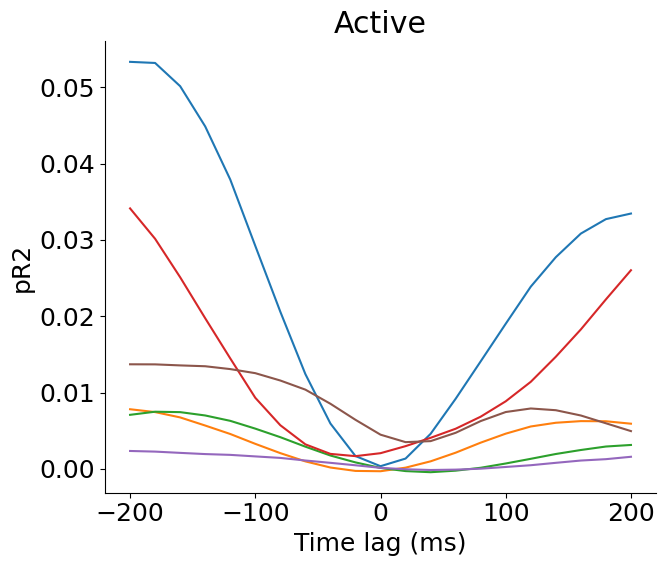

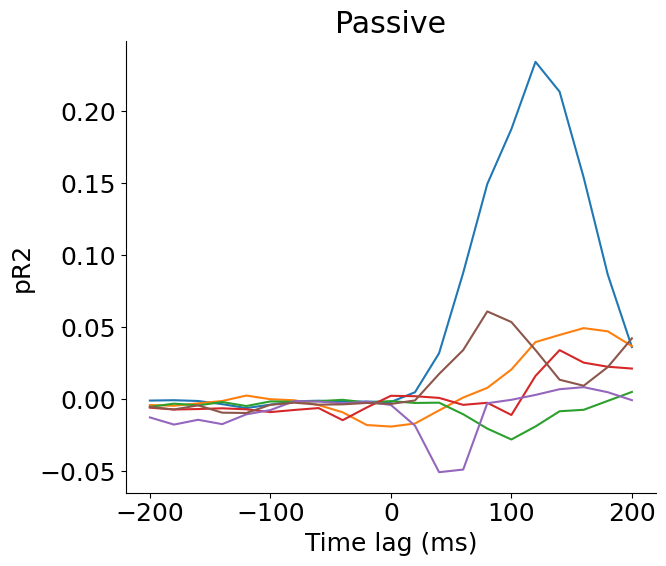

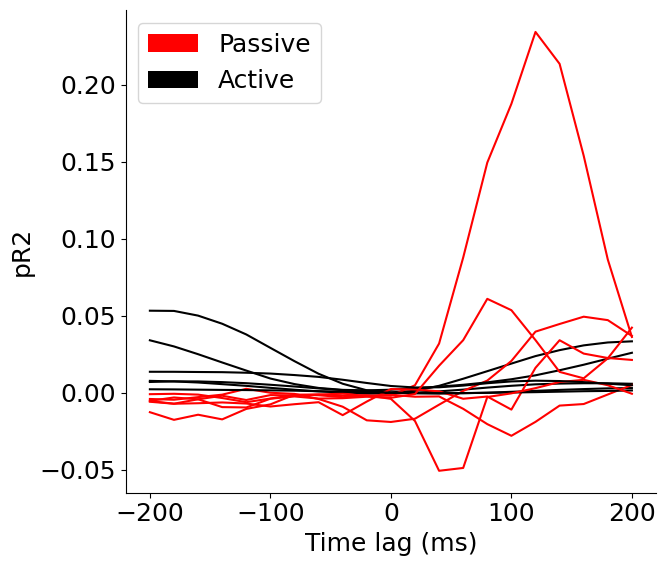

In [21]:
fig, ax = plt.subplots(figsize=(7, 6))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for i in thresh_idx:
    plt.plot(lag_range,active_pR2[:,i])
plt.title('Active')
plt.xlabel('Time lag (ms)')
plt.ylabel('pR2')
plt.tight_layout()
# plt.savefig(figDir + monkey +'_thresh_act.pdf', dpi = 'figure')
plt.show()

fig, ax = plt.subplots(figsize=(7, 6))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for i in thresh_idx:
    plt.plot(lag_range,passive_pR2[:,i])
plt.title('Passive')
plt.xlabel('Time lag (ms)')
plt.ylabel('pR2')
plt.tight_layout()
# plt.savefig(figDir + monkey +'_thresh_pas.pdf', dpi = 'figure')
plt.show()

fig, ax = plt.subplots(figsize=(7, 6))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for i in thresh_idx:
    plt.plot(lag_range,active_pR2[:,i],color = 'k')
    plt.plot(lag_range,passive_pR2[:,i],color = 'red')
plt.xlabel('Time lag (ms)')
plt.ylabel('pR2')
legend_elements = [Patch(facecolor='red', label='Passive'),Patch(facecolor='k', label='Active')]
plt.legend(handles=legend_elements)
# plt.axvline(60,color= 'k', linestyle='--')
plt.tight_layout()
# plt.savefig(figDir + monkey +'_thresh.pdf', dpi = 'figure')
plt.show()

[23.636363636363637, 74.54545454545455]
[40.0, 100.0]


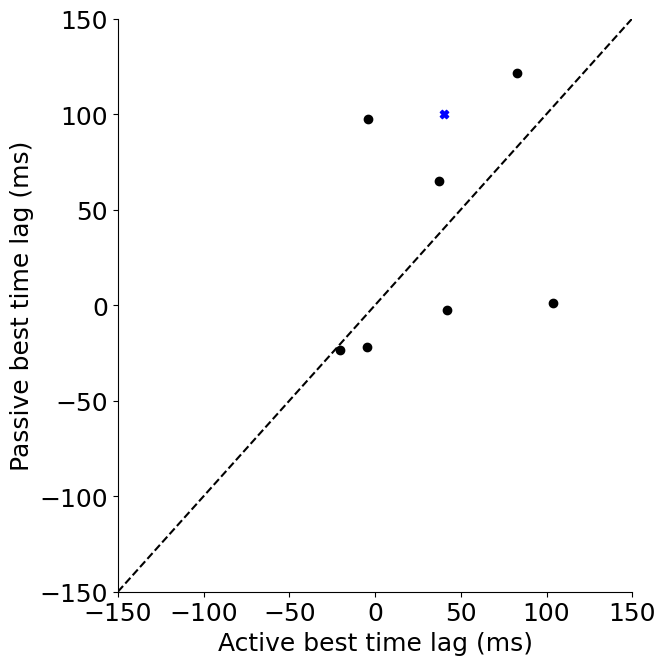

In [19]:
thresh_active_lags_rand = np.add(thresh_active_lags, np.random.uniform(low=-5, high=5, size=(len(thresh_active_lags),)))
thresh_passive_lags_rand = np.add(thresh_passive_lags, np.random.uniform(low=-5, high=5, size=(len(thresh_passive_lags),)))

fig, ax = plt.subplots(figsize=(7, 7))
# ax.set_xlim(0,150)
# ax.set_ylim(0,150)
ax.set_xlim(-150,150)
ax.set_ylim(-150,150)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("Passive best time lag (ms)")
ax.set_xlabel("Active best time lag (ms)")
ax.scatter(thresh_active_lags_rand, thresh_passive_lags_rand,color = 'k')
ax.scatter(np.median(thresh_active_lags), np.median(thresh_passive_lags), marker = 'X', color = 'blue')
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="k")
print([np.mean(thresh_active_lags),np.mean(thresh_passive_lags)])
print([np.median(thresh_active_lags),np.median(thresh_passive_lags)])
plt.tight_layout()
# plt.savefig(figDir + monkey +'_thresh_scatter.pdf', dpi = 'figure')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlim(0,0.8)
ax.set_ylim(0,0.8)
ax.set_ylabel("Passive best pR2")
ax.set_xlabel("Active best pR2")
ax.scatter(thresh_active_r2s, thresh_passive_r2s,color = 'k')
ax.scatter(np.mean(thresh_active_r2s), np.mean(thresh_passive_r2s), marker = 'X', color = 'blue')
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="k")
print([np.mean(thresh_active_r2s),np.mean(thresh_passive_r2s)])

In [71]:
#Get a specific neuron's original index
with np.load(monkey+'_hf_neuron_filter.npz') as data:
    neuron_filter = data['neuron_filter']
fr_filtered_idx = np.argwhere(neuron_filter==1).flatten()
index_in_glm = [30, 37, 38, 42, 44, 88, 90, 98]
index_original = fr_filtered_idx[index_in_glm]
print(index_original)

[ 39  46  47  52  54  99 101 109]


## Use decoder weights to filter

In [ ]:
# Take top neurons that contribute most to the decoder and see their GLM performance
monkey = "Han_20171207"
with np.load(monkey+'_act_acc_decoder_weights.npz') as data:
    eff_weights = data['eff_weights']
    aff_weights = data['aff_weights']

# with np.load(monkey+'_pas_acc_decoder_weights_lasso.npz') as data:
#     aff_weights = data['aff_weights']

sum_weights = np.mean(abs(eff_weights), axis=0)
sorted_idx = np.argsort(sum_weights)[::-1]

with np.load(monkey+'_hf_neuron_filter.npz') as data:
    neuron_filter = data['neuron_filter']
fr_filtered_idx = np.argwhere(neuron_filter==1).flatten()

N = 20
print(sorted_idx[:N])
print(neuron_filter[sorted_idx[:N]])

glm_filtered_idx = np.array([np.argwhere(fr_filtered_idx==i).flatten() for i in sorted_idx[:N]]).flatten()
print(glm_filtered_idx)
print(glm_filtered_idx.shape)
# glm_filtered_idx = np.concatenate(glm_filtered_idx)
print(glm_filtered_idx)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(0,0.8)
ax.set_ylim(0,0.8)
ax.set_ylabel("Passive best psuedo-R2")
ax.set_xlabel("Active best psuedo-R2")
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="k")

act_decoder_filtered_r2 = active_r2s[glm_filtered_idx]
pas_decoder_filtered_r2 = passive_r2s[glm_filtered_idx]

plt.scatter(act_decoder_filtered_r2, pas_decoder_filtered_r2, color='k')
ax.scatter(np.mean(act_decoder_filtered_r2), np.mean(pas_decoder_filtered_r2), marker = 'X', color = 'blue')

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_xlim(-10,150)
# ax.set_ylim(-10,150)
ax.set_ylabel("Passive best lag")
ax.set_xlabel("Active best lag")
# ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="k")

act_decoder_filtered_lags = active_lags[glm_filtered_idx]
pas_decoder_filtered_lags = passive_lags[glm_filtered_idx]
ax.scatter(np.median(act_decoder_filtered_lags), np.median(pas_decoder_filtered_lags), marker = 'X', color = 'blue',zorder = 99)
act_decoder_filtered_lags = np.add(act_decoder_filtered_lags, np.random.uniform(low=-5, high=5, size=(len(act_decoder_filtered_lags),)))
pas_decoder_filtered_lags = np.add(pas_decoder_filtered_lags, np.random.uniform(low=-5, high=5, size=(len(pas_decoder_filtered_lags),)))

plt.scatter(act_decoder_filtered_lags, pas_decoder_filtered_lags, color='k')
plt.tight_layout()
# plt.savefig(figDir + monkey +'_topActDecod_scatter.pdf', dpi = 'figure')

In [ ]:

fig, ax = plt.subplots(figsize=(6, 5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for i in glm_filtered_idx:
    plt.plot(range(-200, 201, 20),active_pR2[:,i])
plt.title('Active')
plt.xlabel('Time lag (ms)')
plt.ylabel('pR2')
plt.xlim([-200,200])
# plt.ylim([-0.05,0.35])
plt.tight_layout()
# plt.savefig(figDir + monkey +'_topPasDecod_act.pdf', dpi = 'figure')
plt.show()

fig, ax = plt.subplots(figsize=(6, 5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for i in glm_filtered_idx:
    plt.plot(range(-200, 201, 20),passive_pR2[:,i])
plt.title('Passive')
plt.xlabel('Time lag (ms)')
plt.ylabel('pR2')
plt.xlim([-200,200])
# plt.ylim([-0.15,0.55])
plt.tight_layout()
# plt.savefig(figDir + monkey +'_topPasDecod_pas.pdf', dpi = 'figure')
plt.show()

fig, ax = plt.subplots(figsize=(6, 5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for i in glm_filtered_idx:
    plt.plot(range(-200, 201, 20),active_pR2[:,i],color = 'k')
    plt.plot(range(-200, 201, 20),passive_pR2[:,i],color = 'red')
plt.xlabel('Time lag (ms)')
plt.ylabel('psuedo-R2')
legend_elements = [Patch(facecolor='red', label='Passive'),Patch(facecolor='k', label='Active')]
# plt.legend(handles=legend_elements)
plt.xlim([-200,200])
# plt.ylim([-0.15,0.55])
plt.tight_layout()
# plt.savefig(figDir + monkey +'_topPasDecod.pdf', dpi = 'figure')
plt.show()

# cross GLM

### Fit

In [ ]:
#Data selection params
encoding_bin_size = int(20)
lag_range = np.arange(-200,201,20)

# Act - Pas
active_df = dataset.make_trial_data(align_field='move_onset_time', align_range=(0,500), ignored_trials=~active_mask)
active_spikes_resampled = resample(active_df.spikes.to_numpy(),encoding_bin_size)*1000 
active_behav = np.concatenate((active_df['hand_vel'].to_numpy(),active_df['hand_acc'].to_numpy()),axis=1)
active_behav = resample(active_behav,encoding_bin_size)
passive_df = dataset.make_trial_data(align_field='move_onset_time', align_range=(0,120), ignored_trials=~passive_mask)
passive_spikes_resampled = resample(passive_df.spikes.to_numpy(),encoding_bin_size)*1000
passive_behav = np.concatenate((passive_df['hand_vel'].to_numpy(),passive_df['hand_acc'].to_numpy()),axis=1)
passive_behav = resample(passive_behav,encoding_bin_size)

fr_thresh = 1 #in Hz
neuron_filter = np.logical_and(np.mean(active_spikes_resampled,axis = 0) > fr_thresh, np.mean(passive_spikes_resampled,axis = 0) > fr_thresh)
n_high_neurons = np.sum(neuron_filter)
print(n_high_neurons,'high fr neurons')

high_nrn_idx = np.argwhere(neuron_filter == 1)
pool = mp.Pool(mp.cpu_count())
actpas_pR2 = [pool.starmap(mp_cross_glm_pr2, [(dataset, 'active', 'passive', (0,500), (0,120), active_behav, passive_behav, active_cond_dict, encoding_bin_size, lag_range, nrn_idx) for nrn_idx in high_nrn_idx])][0]
pool.close()

np.savez(monkey+'_actpas_VA2020_500120_pR2', actpas_pR2 = actpas_pR2) 

# # Pas - Act
# active_df = dataset.make_trial_data(align_field='move_onset_time', align_range=(0,120), ignored_trials=~active_mask)
# active_spikes_resampled = resample(active_df.spikes.to_numpy(),encoding_bin_size)*1000 
# active_behav = np.concatenate((active_df['hand_vel'].to_numpy(),active_df['hand_acc'].to_numpy()),axis=1)
# active_behav = resample(active_behav,encoding_bin_size)
# passive_df = dataset.make_trial_data(align_field='move_onset_time', align_range=(0,120), ignored_trials=~passive_mask)
# passive_spikes_resampled = resample(passive_df.spikes.to_numpy(),encoding_bin_size)*1000
# passive_behav = np.concatenate((passive_df['hand_vel'].to_numpy(),passive_df['hand_acc'].to_numpy()),axis=1)
# passive_behav = resample(passive_behav,encoding_bin_size)

# fr_thresh = 1 #in Hz
# neuron_filter = np.logical_and(np.mean(active_spikes_resampled,axis = 0) > fr_thresh, np.mean(passive_spikes_resampled,axis = 0) > fr_thresh)
# n_high_neurons = np.sum(neuron_filter)
# print(n_high_neurons,'high fr neurons')

# high_nrn_idx = np.argwhere(neuron_filter == 1)
# pool = mp.Pool(mp.cpu_count())
# pasact_pR2 = [pool.starmap(mp_cross_glm_pr2, [(dataset, 'passive', 'active', (0,120), (0,120),passive_behav, active_behav, passive_cond_dict, encoding_bin_size, lag_range, nrn_idx) for nrn_idx in high_nrn_idx])][0]
# pool.close()
# np.savez(monkey+'_pasact_VA2020_120120_pR2', pasact_pR2 = pasact_pR2) 

### Plot

In [ ]:
monkey = "Han_20171207"
with np.load(monkey+'_actpas_VA2020_500120_pR2.npz') as data:
    actpas_pR2 = data['actpas_pR2']
lag_range = np.arange(-200, 201, 20)
n_high_neurons = actpas_pR2.shape[0]
print(n_high_neurons,'neurons')
active_pR2 = actpas_pR2[:,0,:] #shape = (n_neurons, n_lags)
passive_pR2 = actpas_pR2[:,1,:]

# monkey = "Han_20171207"
# with np.load(monkey+'_pasact_VA2020_120500_pR2.npz') as data:
#     pasact_pR2 = data['pasact_pR2']
# lag_range = np.arange(-200, 201, 20)
# n_high_neurons = pasact_pR2.shape[0]
# print(n_high_neurons,'neurons')
# passive_pR2 = pasact_pR2[:,0,:] #shape = (n_neurons, n_lags)
# active_pR2 = pasact_pR2[:,1,:]

### w/o Thresh

In [ ]:
active_r2s = np.nanmax(active_pR2,axis = 1) #highest pr2 in active condition that encode neurons
passive_r2s = np.nanmax(passive_pR2,axis = 1) #pasisve condition
plt.hist(active_r2s,alpha = 0.5,label = 'Active')
plt.hist(passive_r2s,alpha = 0.5,label = 'Passive')
plt.xlabel("Best pseudo-R2")
plt.ylabel("Neuron count")
plt.title('Distribution of best pR2')
plt.legend()

In [ ]:
active_lags = lag_range[np.argmax(active_pR2,axis = 1)] #best time lags in active condition that encode all neurons
passive_lags = lag_range[np.argmax(passive_pR2,axis = 1)] #pasisve condition
plt.hist(active_lags,alpha = 0.5,label = 'Active')
plt.hist(passive_lags,alpha = 0.5,label = 'Passive')
plt.xlabel("Best time lag (ms)")
plt.ylabel("Neuron count")
plt.title('Distribution of best time lags')
plt.legend()
print([stats.mode(active_lags), stats.mode(passive_lags)])

In [ ]:
# Add jitter to best time lags for visualization
active_lags_rand = np.add(active_lags, np.random.uniform(low=-5, high=5, size=(len(active_lags),)))
passive_lags_rand = np.add(passive_lags, np.random.uniform(low=-5, high=5, size=(len(passive_lags),)))

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlim(-225,225)
ax.set_ylim(-225,225)
ax.set_ylabel("Passive best time lag (ms)")
ax.set_xlabel("Active best time lag (ms)")
ax.scatter(active_lags_rand, passive_lags_rand,color = 'k')
ax.scatter(np.mean(active_lags), np.mean(passive_lags), marker = 'X', color = 'blue')
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="k")
print('Mean:',[np.mean(active_lags),np.mean(passive_lags)])
print('Median:',[np.median(active_lags),np.median(passive_lags)])

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
# ax.set_xlim(0,0.8)
# ax.set_ylim(0,0.8)
ax.set_ylabel("Passive best pR2")
ax.set_xlabel("Active best pR2")
ax.scatter(active_r2s, passive_r2s,color = 'k')
ax.scatter(np.mean(active_r2s), np.mean(passive_r2s), marker = 'X', color = 'blue')
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="k")
print([np.mean(active_r2s),np.mean(passive_r2s)])

### Thresh

In [ ]:
# time_threshold_1 = 20
# # time_threshold_2 = 200
# pR2_threshold = 0.01
# thresh_active_lags = []
# thresh_passive_lags = []
# thresh_active_r2s = []
# thresh_passive_r2s = []
# for i in range(n_high_neurons):
#     time_thresh_idx1 = np.argwhere(lag_range==time_threshold_1)[0,0]+1
#     # time_thresh_idx2 = np.argwhere(lag_range==time_threshold_2)[0,0]+1
#     act = active_pR2[i,:]
#     pas = passive_pR2[i,:]
#     if np.argmax(act) >= time_thresh_idx1 and np.argmax(pas) >= time_thresh_idx1:
#         if np.nanmax(act) >= pR2_threshold and np.nanmax(pas) >= pR2_threshold:
#         # if np.nanmax(act)/np.nanmax(pas) > 1.4 and np.nanmax(act) >= pR2_threshold:
#         # if np.nanmax(act)/np.nanmax(pas) < 0.7 and np.nanmax(pas) >= pR2_threshold:    
#         # if 0.7 < np.nanmax(act)/np.nanmax(pas) < 1.4 and np.nanmax(act) >= pR2_threshold and np.nanmax(pas) >= pR2_threshold:
#             thresh_active_r2s.append(np.nanmax(act))
#             thresh_passive_r2s.append(np.nanmax(pas))        
#             thresh_active_lags.append(lag_range[np.argmax(act)])
#             thresh_passive_lags.append(lag_range[np.argmax(pas)])
# print(len(thresh_active_lags),'neurons after thresholding')

thresh_active_lags = active_lags[thresh_idx]
thresh_passive_lags = passive_lags[thresh_idx]
thresh_active_r2s = active_r2s[thresh_idx]
thresh_passive_r2s = passive_r2s[thresh_idx]    

In [ ]:
thresh_active_lags_rand = np.add(thresh_active_lags, np.random.uniform(low=-5, high=5, size=(len(thresh_active_lags),)))
thresh_passive_lags_rand = np.add(thresh_passive_lags, np.random.uniform(low=-5, high=5, size=(len(thresh_passive_lags),)))

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
# ax.set_xlim(15,225)
# ax.set_ylim(15,225)
ax.set_ylabel("Passive best time lag (ms)")
ax.set_xlabel("Active best time lag (ms)")
ax.scatter(thresh_active_lags_rand, thresh_passive_lags_rand,color = 'k')
ax.scatter(np.mean(thresh_active_lags), np.mean(thresh_passive_lags), marker = 'X', color = 'blue')
# ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="k")
print([np.mean(thresh_active_lags),np.mean(thresh_passive_lags)])
print([np.median(thresh_active_lags),np.median(thresh_passive_lags)])

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlim(0,0.8)
ax.set_ylim(0,0.8)
ax.set_ylabel("Passive best pR2")
ax.set_xlabel("Active best pR2")
ax.scatter(thresh_active_r2s, thresh_passive_r2s,color = 'k')
ax.scatter(np.mean(thresh_active_r2s), np.mean(thresh_passive_r2s), marker = 'X', color = 'blue')
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="k")
print([np.mean(thresh_active_r2s),np.mean(thresh_passive_r2s)])

In [ ]:
for i in thresh_idx:
    plt.plot(range(-200, 201, 20),active_pR2[i,:])
plt.title('Active')
plt.xlabel('Time lag (ms)')
plt.ylabel('pR2')
# plt.axvline(60,color= 'k', linestyle='--')
plt.show()

for i in thresh_idx:
    plt.plot(range(-200, 201, 20),passive_pR2[i,:])
plt.title('Passive')
plt.xlabel('Time lag (ms)')
plt.ylabel('pR2')
# plt.ylim(-0.25,0.5)
# plt.axvline(40,color= 'k', linestyle='--')
plt.show()

### Predictions

In [ ]:
#Data selection params
active_align_range = (0,500)
passive_align_range = (0,120)

lag_range = np.arange(-200,201,20)
encoding_bin_size = int(20)

active_behav_df = dataset.make_trial_data(align_field='move_onset_time', align_range=active_align_range, ignored_trials=~active_mask)
active_spikes_resampled = resample(active_behav_df.spikes.to_numpy(),encoding_bin_size)*1000 
active_behav = np.concatenate((active_behav_df['hand_vel'].to_numpy(),active_behav_df['hand_acc'].to_numpy()),axis=1)
active_behav = resample(active_behav,encoding_bin_size)

passive_behav_df = dataset.make_trial_data(align_field='move_onset_time', align_range=passive_align_range, ignored_trials=~passive_mask)
passive_spikes_resampled = resample(passive_behav_df.spikes.to_numpy(),encoding_bin_size)*1000
passive_behav = np.concatenate((passive_behav_df['hand_vel'].to_numpy(),passive_behav_df['hand_acc'].to_numpy()),axis=1)
passive_behav = resample(passive_behav,encoding_bin_size)

fr_thresh = 1 #in Hz
neuron_filter = np.logical_and(np.mean(active_spikes_resampled,axis = 0) > fr_thresh, np.mean(passive_spikes_resampled,axis = 0) > fr_thresh)
thresh_idx_mapped = np.argwhere(neuron_filter==1).flatten()[thresh_idx]
print(thresh_idx)
print(thresh_idx_mapped)

In [ ]:
r2, source_true, source_pred, target_same_lag,target_pred, target_best = pred_cross_glm(dataset, 'active', 'passive', (0,500), (0,120), active_behav, passive_behav, active_cond_dict, encoding_bin_size, lag_range, 28)

In [ ]:
plt.plot(lag_range, r2[0,:])
plt.plot(lag_range, r2[1,:])
print(lag_range[np.argmax(r2[0,:])])
print(lag_range[np.argmax(r2[1,:])])

In [ ]:
source_true = source_true.reshape(active_n_trials,-1)
source_pred = source_pred.reshape(active_n_trials,-1)
target_same_lag = target_same_lag.reshape(passive_n_trials,-1)
target_pred = target_pred.reshape(passive_n_trials,-1)
target_best = target_best.reshape(passive_n_trials,-1)

In [ ]:
fig,ax = plt.subplots(figsize=(16,4))
plt.bar(range(0,25),np.mean(source_true,axis=0),color = 'grey')
plt.plot(np.mean(source_pred,axis=0),color = 'magenta')

In [ ]:
fig,ax = plt.subplots(figsize=(16,4))
plt.plot(np.mean(target_pred,axis=0),color = 'magenta')
plt.bar(range(0,6),np.mean(target_same_lag,axis=0),color = 'grey')

In [ ]:
fig,ax = plt.subplots(figsize=(16,4))
plt.plot(np.mean(target_pred,axis=0),color = 'magenta')
plt.bar(range(0,6),np.mean(target_best,axis=0),color = 'grey')